## Dog and Cat Classification Task

### Steps to Solve the task

1. Import all the necessary Dependencies we will need.
2. Import the Datasets to be used.
3. Build a class that will take the data in and perform some basic transformations on it.
4. Define the neural network architecture. For this Binary class, we'll be using the CNN architecture.
5. Train the model
6. Make predictions
7. Evaluate the model



#### Step 1

Install all the dependencies and load them

In [1]:
!pip install torch_summary
!pip install imgaug

In [2]:
import torchvision
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from imgaug import augmenters as iaa
from torchsummary import summary
import torch
import torch.nn.functional as F
from torchvision import transforms, datasets, models
import pandas as pd
import cv2
from glob import glob
from torch.utils.data import DataLoader, Dataset

### Step 2 - Load data

Here we read the data from its directory where it was stored. This is done for both the train and test set.

In [3]:
train_data_dir = '/kaggle/input/cats-and-dogs/training_set/training_set'
test_data_dir = '/kaggle/input/cats-and-dogs/test_set/test_set'

### Step 3 -  Dataset Handler



Create the class for the dataset.
We load the image data here, resize it and convert it to tensors that will be run on the gpu.

In [4]:
# Build a Dataset class for the data
class cats_dogs(Dataset):
    def __init__(self, folder):
        super().__init__()
        cats = glob(folder+'/cats/*.jpg')
        dogs = glob(folder+'/dogs/*.jpg')
        self.fpaths = cats + dogs
        from random import shuffle, seed; seed(10); shuffle(self.fpaths)
        self.targets = [fpath.split('/')[-1].startswith('dog') for fpath in self.fpaths] # dogs=1, cats =0
    def __len__(self): return len(self.fpaths)
    def __getitem__(self, index):
        f = self.fpaths[index]
        target = self.targets[index]
        im = (cv2.imread(f)[:,:,::-1])
        im = cv2.resize(im, (224, 224))
        return torch.tensor(im/255).permute(2,0,1).float(), torch.tensor([target]).float()

#### Show a random sample of the image we have

In [5]:
data = cats_dogs(train_data_dir)
im, label = data[200]

tensor([1.])


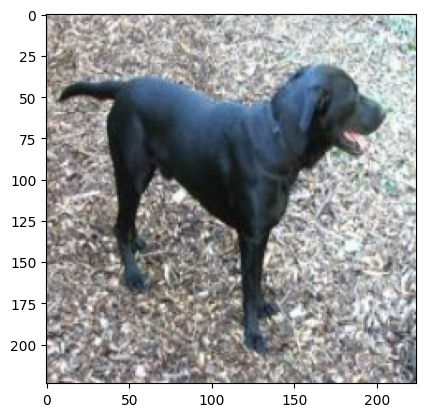

In [6]:
plt.imshow(im.permute(1,2,0))
print(label)

#### Step 4 -  Model Architecture

#### Define a basic Convolution Network to be used

The convolution layer consist of:
1. Convolution layer
2. An activation function, the Relu was chosen in this case
3. Batch Normalization was applied 
4. Max Pooling was applied to reduce the dimensions of the output from the convolution operation, picking only the highest value from the kernel.

In [7]:
# define a function for the convolution that will be used in building the architecture
def conv_layer(input_channel, number_output, kernel_size, stride=1):
    return nn.Sequential(
        nn.Conv2d(input_channel, number_output, kernel_size),
        nn.ReLU(),
        nn.BatchNorm2d(number_output),
        nn.MaxPool2d(2)
    )

#### Build the Architecture for the model. 

1. Six Convolution layers
2. A flattened Layer
3. A linear fully connected layer
4. The output layer should have  one neuron that outputs the class.
5. The loss function is Binary Cross Entropy Loss, which is good for our case because we're working on a binary classification task. For classes
greater than 2, we would use Categorical Cross Entropy loss.

In [8]:
# build the model architecture
def get_model():
    model  = nn.Sequential(
        conv_layer(3, 64, 3),
        conv_layer(64, 512, 3),
        conv_layer(512, 512, 3),
        conv_layer(512, 512, 3),
        conv_layer(512, 512, 3),
        conv_layer(512, 512, 3),
        nn.Flatten(),
        nn.Linear(512, 1),
        nn.Sigmoid()
    )
    
    loss_fn = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    return model, loss_fn, optimizer

### Let's have a peek into the model and the paramaters it has

In [9]:
model, loss_fn, optimizer = get_model()

# model summary
summary(model, torch.zeros(1,3,224,224))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 64, 111, 111]        --
|    └─Conv2d: 2-1                       [-1, 64, 222, 222]        1,792
|    └─ReLU: 2-2                         [-1, 64, 222, 222]        --
|    └─BatchNorm2d: 2-3                  [-1, 64, 222, 222]        128
|    └─MaxPool2d: 2-4                    [-1, 64, 111, 111]        --
├─Sequential: 1-2                        [-1, 512, 54, 54]         --
|    └─Conv2d: 2-5                       [-1, 512, 109, 109]       295,424
|    └─ReLU: 2-6                         [-1, 512, 109, 109]       --
|    └─BatchNorm2d: 2-7                  [-1, 512, 109, 109]       1,024
|    └─MaxPool2d: 2-8                    [-1, 512, 54, 54]         --
├─Sequential: 1-3                        [-1, 512, 26, 26]         --
|    └─Conv2d: 2-9                       [-1, 512, 52, 52]         2,359,808
|    └─ReLU: 2-10                        [-1, 512, 52, 52]        

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 64, 111, 111]        --
|    └─Conv2d: 2-1                       [-1, 64, 222, 222]        1,792
|    └─ReLU: 2-2                         [-1, 64, 222, 222]        --
|    └─BatchNorm2d: 2-3                  [-1, 64, 222, 222]        128
|    └─MaxPool2d: 2-4                    [-1, 64, 111, 111]        --
├─Sequential: 1-2                        [-1, 512, 54, 54]         --
|    └─Conv2d: 2-5                       [-1, 512, 109, 109]       295,424
|    └─ReLU: 2-6                         [-1, 512, 109, 109]       --
|    └─BatchNorm2d: 2-7                  [-1, 512, 109, 109]       1,024
|    └─MaxPool2d: 2-8                    [-1, 512, 54, 54]         --
├─Sequential: 1-3                        [-1, 512, 26, 26]         --
|    └─Conv2d: 2-9                       [-1, 512, 52, 52]         2,359,808
|    └─ReLU: 2-10                        [-1, 512, 52, 52]        

### Define functions to load and train the model.

The  get_data function will load the data from the respective directories.

It loads the image data in batches of 32 as seen below. 

The shuffling is set to True to add randomness to how the  data is being taken.

In [10]:
def get_data():
    train = cats_dogs(train_data_dir)
    trn_dl = DataLoader(train, batch_size=32, shuffle=True, drop_last=True)
    val = cats_dogs(test_data_dir)
    val_dl = DataLoader(val, batch_size=32, shuffle=True, drop_last=True)
    return trn_dl, val_dl

We are ignoring the last batch by setting drop_last = True. We do this because the size of the last batch  may not be like that of the rest.

In [11]:
# define a function to train the model on a batch of data
def train_batch(x, y, model, opt, loss_fn):
    model.train()
    prediction  = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()
    

In [12]:
# define accuracy function
@torch.no_grad()
def accuracy(x, y, model):
    prediction = model(x)
    is_correct = (prediction > 0.5) == y
    return is_correct.cpu().numpy().tolist()

In [13]:
# define Validation loss calculation function
@torch.no_grad()
def val_loss(x, y, model):
    prediction = model(x)
    val_loss = loss_fn(prediction, y)
    return val_loss.item()

In [14]:
# fetch the required dataloaders
trn_dl, val_dl = get_data()

In [15]:
# Identify the device (GPU if available, else CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move the model to the device
model.to(device)

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    (0): Conv2d(64, 512, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (2): Sequential(
    (0): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (3): Sequential(
    (0): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_runni

#### Step 6  - Train the model

In [16]:
# train the model over 5 epochs
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []

for epoch in range(5):
    print(epoch)
    
    train_epoch_losses, train_epoch_accuracies = [], []
    val_epoch_accuracies = []
    
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        x, y = x.to(device), y.to(device) 
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss)
    train_epoch_loss = np.array(train_epoch_losses).mean()
    
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        x, y = x.to(device), y.to(device) 
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)
    
    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        x, y = x.to(device), y.to(device) 
        val_is_correct = accuracy(x, y, model)
        val_epoch_accuracies.extend(val_is_correct)
    val_epoch_accuracy = np.mean(val_epoch_accuracies)
    
    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_accuracies.append(val_epoch_accuracy)

0
1
2
3
4


####  Step  7  - Visualization

### Visualization of how our model is peforming on both train and test set

/tmp/ipykernel_34/1713872572.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


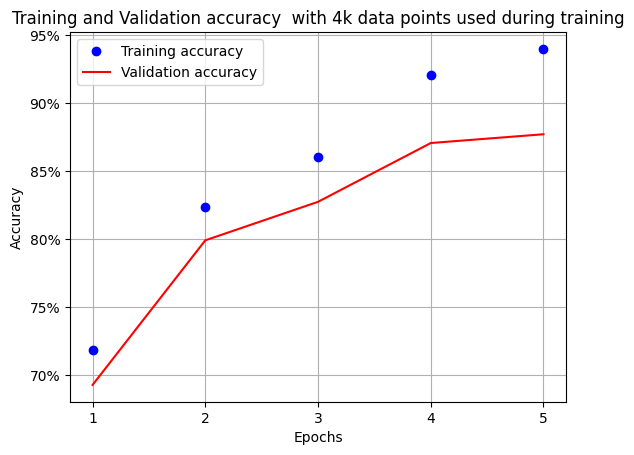

In [17]:
epochs = np.arange(5)+1
import matplotlib.ticker as mtick


plt.plot(epochs, train_accuracies, 'bo', label="Training accuracy")
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mtick.MultipleLocator(1))
plt.title("Training and Validation accuracy  with 4k data points used during training")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
plt.legend()
plt.grid('off')
plt.show()